## 019 Compare performance of binomial vs normal craving estimation (single subject)

Date: 04.Aug.2022

### Purpose

Directly compare the model performance between binomial estimation and normal estimation of craving using WAIC/LOO.

### Outline of Plan

1. Copy over RetroPrototype child classes from latest_models_normal.py as NormRetroPrototype
2. Copy over RetroPrototype child classes from latest_models_binomial.py as BinomRetroPrototype
3. Run 3 from each type in one batchfit object and directly compare with WAIC/LOO

### What we did in this notebook

1. Ran passive + active 0-, 1-, 2-step models for subject 8
2. Visualized true vs predicted cravings for a relatively good subject (8), both look plausible, binomial looks slightly better
3. Saved traces to 19_trace_output/. Need to write code to load traces.
4. Direct comparison of normal and binomial models is impossible, because log-likelihoods are on different scales.

### Overall conclusions
1. Best educated guess is to move forward with binomial model at this point. 
2. 5_joing_model_script.py in online/prolific-food-craving/ directory sets up slurm batch script to run binomial model alternatives on all subjects (only 36 subject from here on out).

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time
import arviz as az

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [4]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.5) & 
    (df_summary['Other Accuracy']>0.5)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
print(pid_list.shape)
longform

(36,)


,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Retrospective prototype class imports

In [9]:
## Normed gaussian classes
from latest_models_normal import P_RW_0step as P0N
from latest_models_normal import P_RW_1stepSep as P1N
from latest_models_normal import P_RW_2stepSep as P2N
from latest_models_normal import A_RW_0step as A0N
from latest_models_normal import A_RW_1stepSep as A1N
from latest_models_normal import A_RW_2stepSep as A2N

## Standard binomial classes
from latest_models_binomial import P_RW_0step as P0B
from latest_models_binomial import P_RW_1stepSep as P1B
from latest_models_binomial import P_RW_2stepSep as P2B
from latest_models_binomial import A_RW_0step as A0B
from latest_models_binomial import A_RW_1stepSep as A1B
from latest_models_binomial import A_RW_2stepSep as A2B

## Batchfit class
from latest_models_normal import BatchFit

## Fit models

In [14]:
p0n = P0N(longform, df_summary, project_dir, None)
p1n = P1N(longform, df_summary, project_dir, None)
p2n = P2N(longform, df_summary, project_dir, None)
a0n = A0N(longform, df_summary, project_dir, None)
a1n = A1N(longform, df_summary, project_dir, None)
a2n = A2N(longform, df_summary, project_dir, None)

p0b = P0B(longform, df_summary, project_dir, None)
p1b = P1B(longform, df_summary, project_dir, None)
p2b = P2B(longform, df_summary, project_dir, None)
a0b = A0B(longform, df_summary, project_dir, None)
a1b = A1B(longform, df_summary, project_dir, None)
a2b = A2B(longform, df_summary, project_dir, None)

In [16]:
for pid_num in [8]:
    p0n.fit(pid_num, 'other')
    p1n.fit(pid_num, 'other')
    p2n.fit(pid_num, 'other')
    a0n.fit(pid_num, 'other')
    a1n.fit(pid_num, 'other')
    a2n.fit(pid_num, 'other')
    p0b.fit(pid_num, 'other')
    p1b.fit(pid_num, 'other')
    p2b.fit(pid_num, 'other')
    a0b.fit(pid_num, 'other')
    a1b.fit(pid_num, 'other')
    a2b.fit(pid_num, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [mod]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [mod]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [mod]
>Metropolis: [craving_sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]
>Metropolis: [mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


In [38]:
save_path_nb14 = f'{root_dir}/bayesian_models/slotscraving/exploration/19_trace_output/'
for pid_num in [8]:
    p0n.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/p0n_{pid_num}_other.nc')
    p1n.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/p1n_{pid_num}_other.nc')
    p1n.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/p1n_{pid_num}_other.nc')
    a0n.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a0n_{pid_num}_other.nc')
    a1n.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a1n_{pid_num}_other.nc')
    a1n.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a1n_{pid_num}_other.nc')

    p0b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/p0b_{pid_num}_other.nc')
    p1b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/p1b_{pid_num}_other.nc')
    p1b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/p1b_{pid_num}_other.nc')
    a0b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a0b_{pid_num}_other.nc')
    a1b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a1b_{pid_num}_other.nc')
    a1b.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/a1b_{pid_num}_other.nc')

In [69]:
# Load instead of fitting
save_path_nb14 = f'{root_dir}/bayesian_models/slotscraving/exploration/14_trace_output/'
for pid_num in [8]:
    # write loading function
    pass

## Output posterior

In [17]:
pid_num = 8

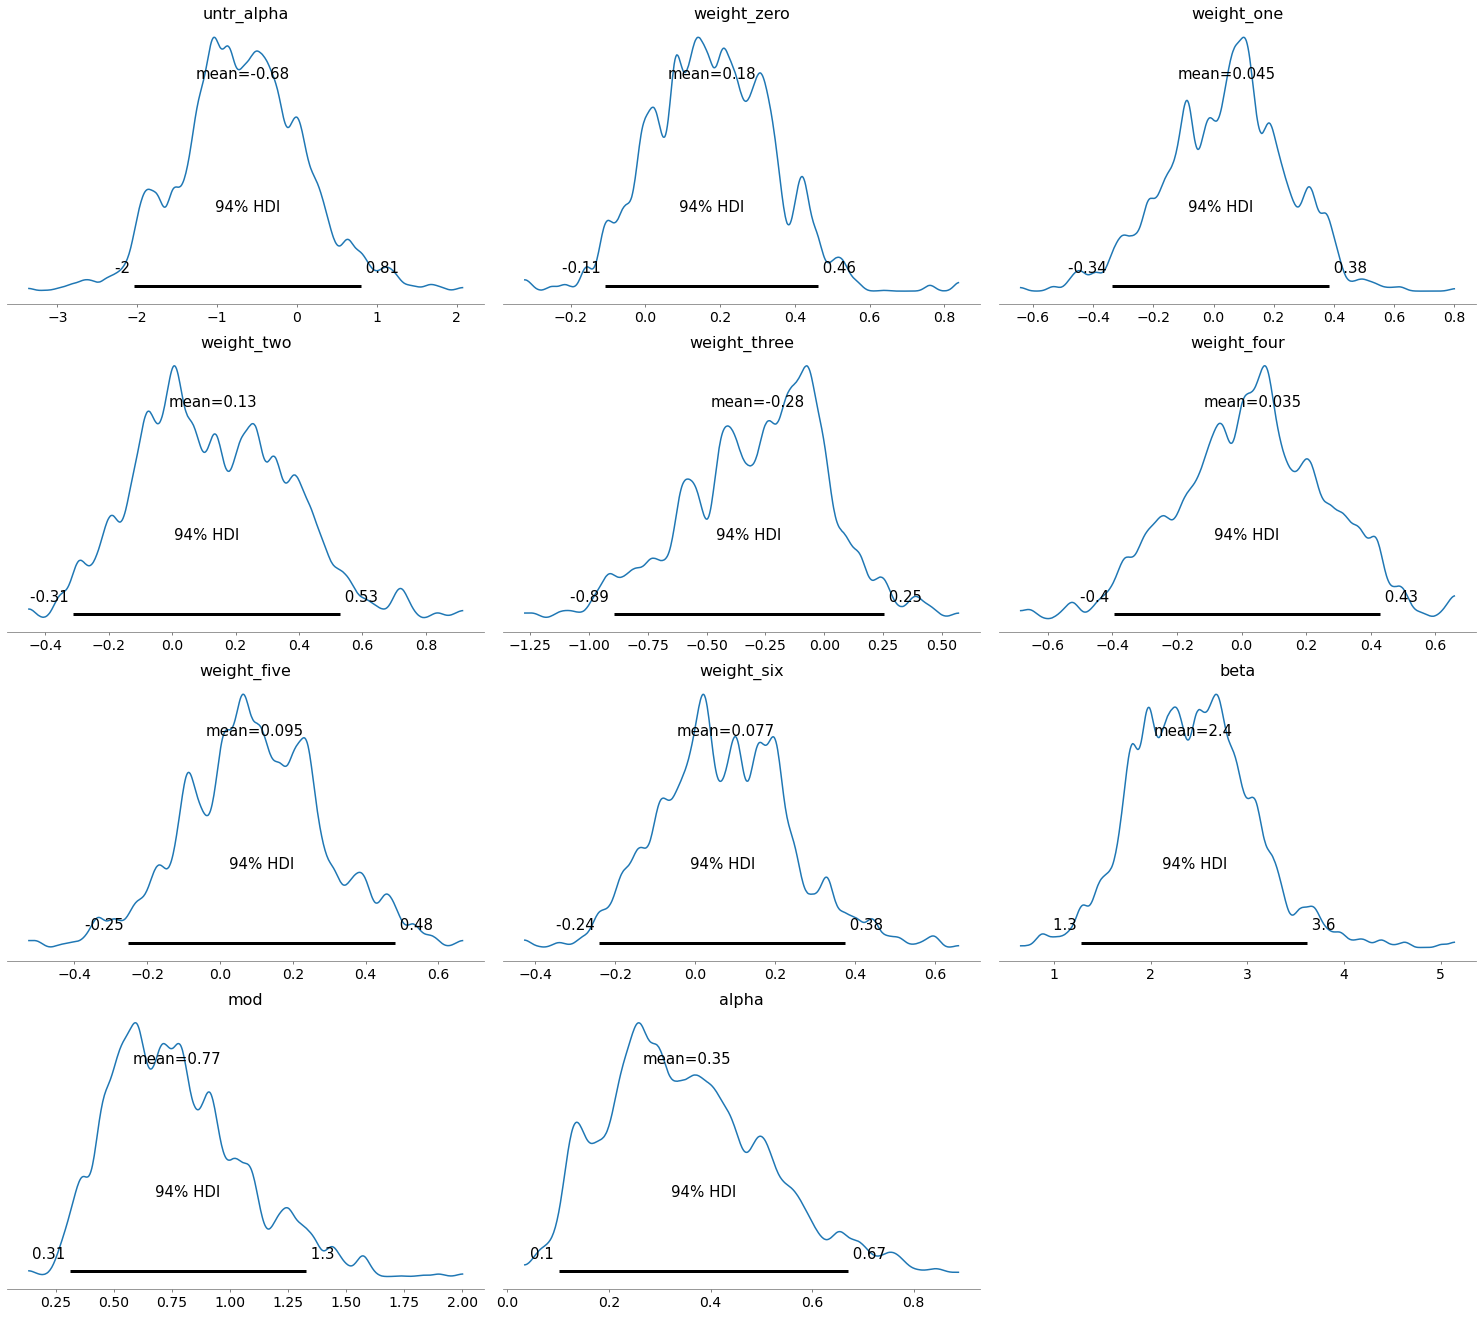

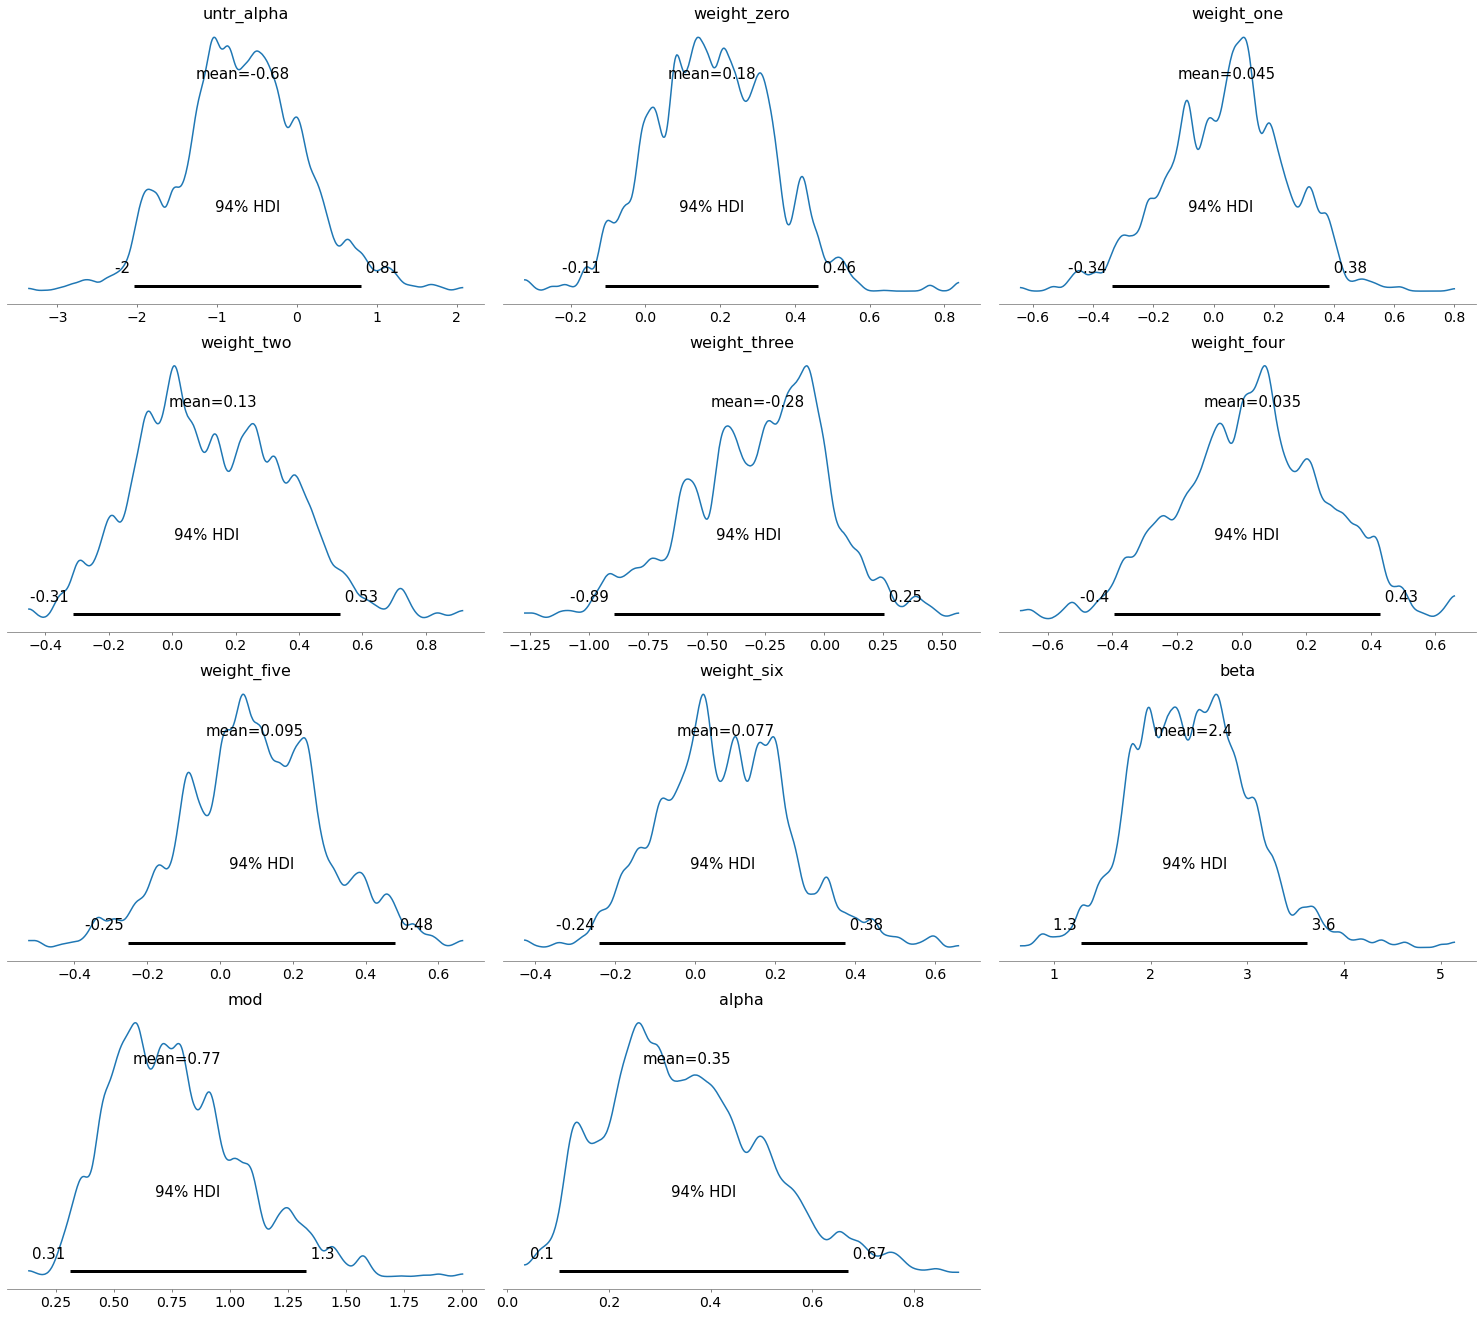

In [18]:
# az.plot_posterior(activev1_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(activev2_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
az.plot_posterior(a2b.traces['other'][pid_list[pid_num]])
plt.tight_layout()
az.plot_posterior(a2b.traces['other'][pid_list[pid_num]])
plt.tight_layout()


## Plotting utils

In [30]:
def plot_ppc_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [34]:
def plot_ppc_norm_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.norm_cravings[b, pid_num].shape[0]),
        y=samp_model.norm_cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.norm_cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


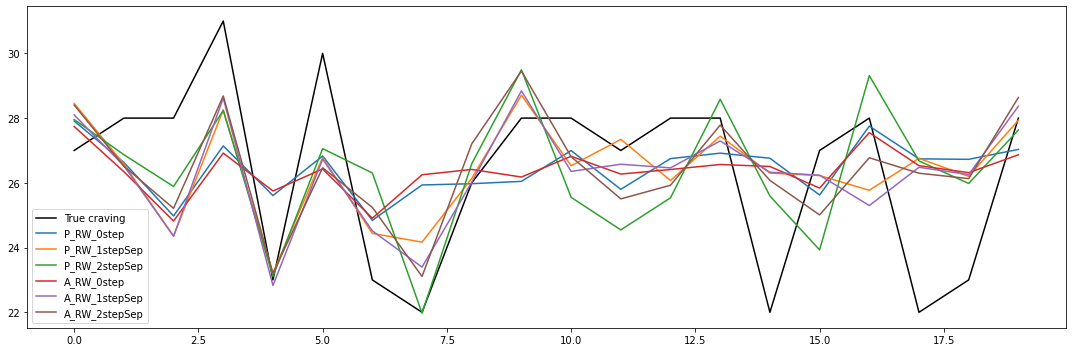

In [35]:
plot_ppc_craving([
    p0b, p1b, p2b,
    a0b, a1b, a2b,
], 8, 'other')

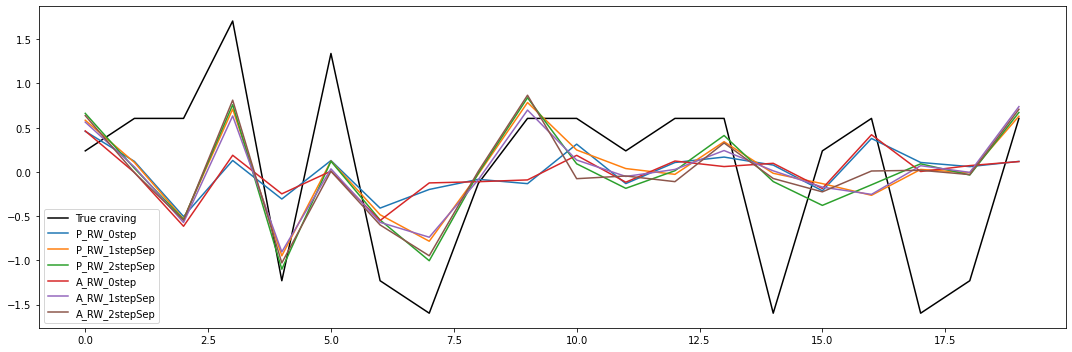

In [37]:
plot_ppc_norm_craving([
    p0n, p1n, p2n,
    a0n, a1n, a2n,
], 8, 'other')

## Model comparison of EV and EVRPE

In [42]:
model_comp = az.compare({
        'Passive0Norm': p0n.traces['other'][pid_list[pid_num]],
        'Passive1Norm': p1n.traces['other'][pid_list[pid_num]],
        'Passive2Norm': p2n.traces['other'][pid_list[pid_num]],
        'Active0Norm': a0n.traces['other'][pid_list[pid_num]],
        'Active1Norm': a1n.traces['other'][pid_list[pid_num]],
        'Active2Norm': a2n.traces['other'][pid_list[pid_num]],
        'Passive0Binom': p0b.traces['other'][pid_list[pid_num]],
        'Passive1Binom': p1b.traces['other'][pid_list[pid_num]],
        'Passive2Binom': p2b.traces['other'][pid_list[pid_num]],
        'Active0Binom': a0b.traces['other'][pid_list[pid_num]],
        'Active1Binom': a1b.traces['other'][pid_list[pid_num]],
        'Active2Binom': a2b.traces['other'][pid_list[pid_num]],
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/jupyter/lib/p

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Passive1Norm,0,-29.327419,3.544834,0.000000,1.000000e+00,2.530621,0.000000,True,log
Active1Norm,1,-29.594190,3.576359,0.266771,1.681710e-13,2.601390,0.356949,True,log
Passive2Norm,2,-29.776751,4.055094,0.449332,0.000000e+00,2.356805,0.542426,True,log
Active2Norm,3,-30.072416,3.921297,0.744996,0.000000e+00,2.228562,0.766657,True,log
Passive0Norm,4,-30.774293,2.783160,1.446874,0.000000e+00,2.421112,1.426618,False,log
Active0Norm,5,-30.801799,2.850117,1.474380,0.000000e+00,2.438188,1.369817,True,log
Active0Binom,6,-51.457760,1.648867,22.130341,0.000000e+00,1.387487,1.511553,False,log
Passive1Binom,7,-51.569751,2.348673,22.242331,0.000000e+00,1.213850,1.442409,False,log
Passive0Binom,8,-51.572856,1.805289,22.245436,0.000000e+00,1.421668,1.523353,False,log
Active1Binom,9,-51.611146,2.262690,22.283726,0.000000e+00,1.241524,1.490424,False,log


<AxesSubplot:xlabel='Log'>

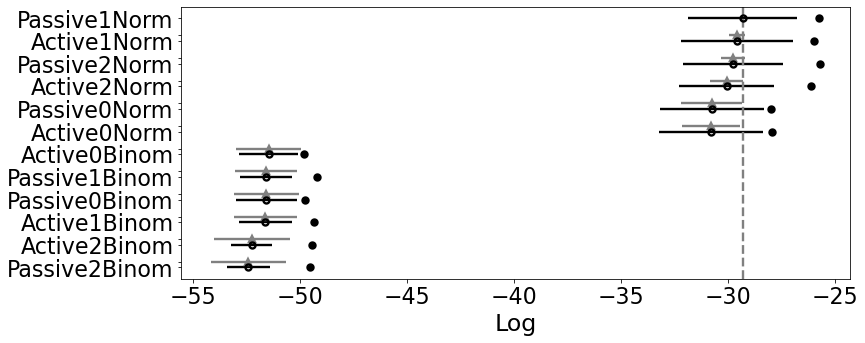

In [43]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))